In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Алгоритмы решения СЛАУ

In [2]:
# метод Гаусса
def gauss(A, b):
    n = len(b)
    x = np.zeros(n)
    iterations = 0
    # Прямой ход
    for k in range(n):
        # выбираем строку с максимальным первым коэффициентом
        max_row = k
        for j in range(k + 1, n):
            if abs(A[j][k]) > abs(A[max_row][k]):
                max_row = j
            A[k], A[max_row] = A[max_row], A[k]
            b[k], b[max_row] = b[max_row], b[k]

        for i in range(k + 1, n):
            # множитель Гаусса
            factor = A[i][k] / A[k][k]
            # вычитаем k-тое первое уравнение начиная с k+1-ого
            for j in range(k + 1, n):
                A[i][j] -= factor * A[k][j]
                iterations += 1
            b[i] -= factor * b[k]
    # Обратный ход
    for k in range(n - 1, -1, -1):
        x[k] = b[k] / A[k][k]
        for j in range(k):
            b[j] -= A[j][k] * x[k]
            iterations += 1
    return x, iterations

# LU - разложение
def LU(A):
  n = len(A)
  U = np.zeros((n, n))
  L = np.zeros((n, n))
  iterations = 0
  for i in range(n):
    L[i][i] = 1
  for i in range(n):
    for j in range(n):
      if i <= j:
        sum = 0
        for k in range(i):
          sum += U[k][j]*L[i][k]
        U[i][j] = A[i][j] - sum
        iterations += 1
      else:
        sum = 0
        for k in range(j):
          sum += U[k][j]*L[i][k]
        L[i][j] = (A[i][j] - sum)/U[j][j]
        iterations += 1
  return L, U, iterations

# решение СЛАУ с использованием LU-разложения
def LU_slay(A, b):
  n = len(A)
  L, U, iterations = LU(A)
  x = np.zeros(n)
  y = np.zeros(n)
  # последовательно выражаем неизвестные в уравнении Ly = b
  for k in range(n):
    y[k] = b[k]
    for j in range(k):
        y[k] -= L[k][j] * y[j]
        iterations += 1
  # последовательно выражаем неизвестные в уравнении Ux = y
  for k in range(n - 1, -1, -1):
    x[k] = y[k] / U[k][k]
    for j in range(k):
      y[j] -= U[j][k] * x[k]
      iterations += 1
  return x, iterations

# итерационное решение СЛАУ с использованием метода Зейделя 
def method_seidel(A, b, eps):
  n = len(A)
  x = np.zeros(n)
  iterations = 0
  continue_work = True
  while continue_work == True:
    x_new = np.copy(x)
    for i in range(n):
      sum1 = sum(A[i][j] * x_new[j] for j in range(i))
      sum2 = sum(A[i][j] * x[j] for j in range(i + 1, n))
      x_new[i] = (b[i] - sum1 - sum2) / A[i][i] 
      iterations += 1
    if np.linalg.norm(x_new - x) < eps:
      continue_work = False
    x = x_new
  return x, iterations


### Исследование реализованных алгоритмов

In [8]:
# Проверка
A = [[3, 2, -5], [2, -1, 3], [1, 2, -1]]
b = [-1, 13, 9]

#A = [[10, 1, -1], [1, 10, -1], [-1, 1, 10]]
#b = [11, 10, 10]
#A = np.array([[35, 10.5, 4], [12, 19.5, 4], [33, 10.5, 49]])
#b = np.array([[-125], [-32], [-161.5]])

A = [[4, 2, -1], [5, 3, -2], [3, 2, -3]]
b = [1, 2, 0]

# ответ [3, 5, 4]
#print(gauss(A, b))
#print(LU_slay(A, b))
print(method_seidel(A, b, 0.0001))

[-0.99971279  2.99947065  0.99993431]


In [5]:
# создание матрицы A
def matrix_A(n):
  A = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i != j:
        A[i][j] = random.choice([0, -1, -2, -3, -4])
  for i in range(n):
    A[i][i] = sum(A[i][j] for j in range(i)) +sum(A[i][j] for j in range(i+1, n))
    if i == 0:
      A[i][i] += 10**(-float(n))
  return A

# свободный член уравнения
def F(A):
  n = len(A)
  # решение x = (1, ..., n)
  x = np.arange(1, n + 1)
  return np.dot(A, x)

In [99]:
# проверка на диагональное преобладание
def diagonal(A):
  n = len(A)
  if (max(sum(abs(A[i][j])/abs(A[i][i]) for j in range(i)) + sum(abs(A[i][j])/abs(A[i][i]) for j in range(i+1, n)) for i in range(n))) < 1.001 :
    return True
  return False

# число обусловленности (для матриц с диагональным преобладанием)
def cond_A(A):
  n = len(A)
  return 1 / (max(abs(A[i][i]) - (sum(A[i][j] for j in range(i)) + sum(A[i][j] for j in range(i+1, n))) for i in range(n)))

In [18]:
def eps(x_):
  n = len(x_)
  # точное решение x = (1, ..., n)
  x = np.arange(1, n + 1)
  s = 0
  for i in range(n):
    s += (x_[i] - x[i])**2
  return np.sqrt(s)

In [70]:
def make_data_A(n):
  cond = []
  eps_lu = []
  eps_seidel = []
  eps_gauss = []
  for i in n:
    A = matrix_A(i)
    b = F(A)
    lu = LU_slay(A, b)[0]
    seidel = method_seidel(A, b, 0.01)[0]
    gaus = gauss(A, b)[0]
    # print("Размерность:", i)
    # print("Ошибка:")
    eps_lu.append(eps(lu))
    # print(" lu:   ", eps(lu))
    eps_seidel.append(eps(seidel))
    # print(" seidel:   ", eps(seidel))
    eps_gauss.append(eps(gaus))
    # print(" gauss:  ", eps(gaus))
    cond.append(cond_A(A))
    # print("Число обусловленности:", cond_A(A))
  return cond, eps_lu, eps_seidel, eps_gauss

Размерность: 5
Ошибка:
 lu:    0.0
 seidel:    0.003729970726813521
 gauss:   0.0
Число обусловленности: 0.05170916278026851
Размерность: 10
Ошибка:
 lu:    4.7311656265286475e-15
 seidel:    0.0007823725566685612
 gauss:   4.289830510009564e-15
Число обусловленности: 0.023099038237263933
Размерность: 15
Ошибка:
 lu:    1.212534334402808e-14
 seidel:    0.0025500238461198233
 gauss:   1.3631802778287419e-14
Число обусловленности: 0.014695134113313198
Размерность: 20
Ошибка:
 lu:    9.454512220249963e-15
 seidel:    0.0015664376070115558
 gauss:   1.7941698724946562e-14
Число обусловленности: 0.011851369971348474
Размерность: 25
Ошибка:
 lu:    2.8051537443747344e-14
 seidel:    0.0020470223788826734
 gauss:   2.7013804640146715e-14
Число обусловленности: 0.009202758079266325
Размерность: 30
Ошибка:
 lu:    2.5611524137444757e-14
 seidel:    0.0017137519092061725
 gauss:   4.53302850937539e-14
Число обусловленности: 0.007489415564017359
Размерность: 50
Ошибка:
 lu:    8.843314925815476e

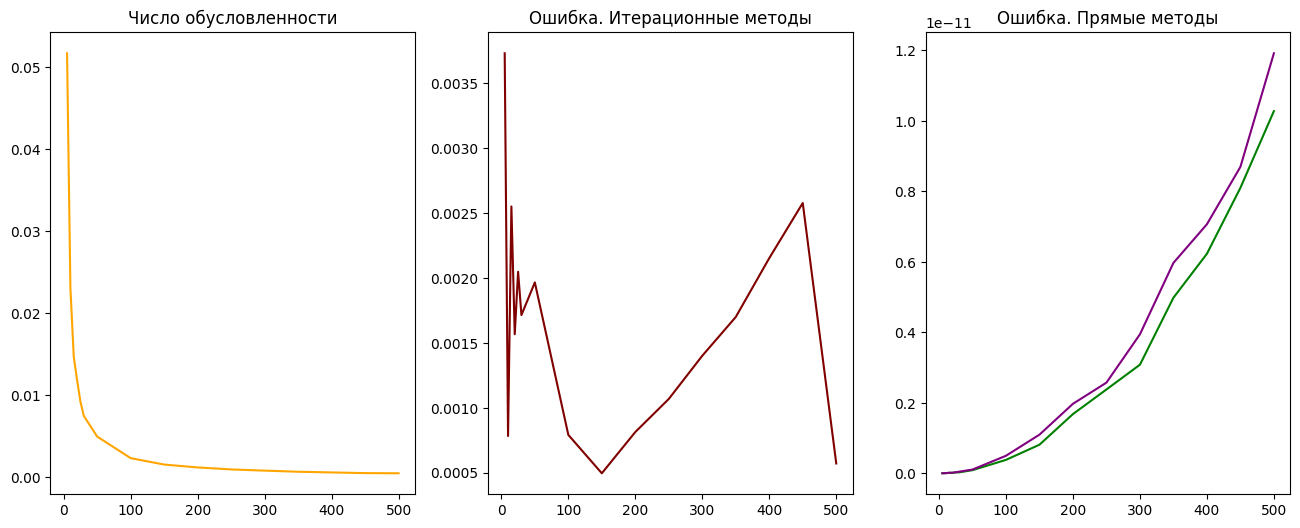

In [69]:
n = np.array([5, 10, 15, 20, 25, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
cond, eps_lu, eps_seidel, eps_gauss = make_data_A(n)
fig, (ax) =  plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(16)
fig.set_figheight(6)
ax[0].plot(n, cond, color = "orange")
ax[2].plot(n, eps_lu, color = "green")
ax[1].plot(n, eps_seidel, color = "maroon")
ax[2].plot(n, eps_gauss, color = "purple")

ax[0].set_title("Число обусловленности")
ax[1].set_title("Ошибка. Итерационные методы")
ax[2].set_title("Ошибка. Прямые методы")
plt.savefig("a")

In [19]:
# создание матрицы Гилберта
def hilbert_matrix(n):
  A = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      A[i][j] = 1 / (i + j + 1)
  return A

def make_data_hilbert(n):
  cond = []
  eps_lu = []
  eps_seidel = []
  eps_gauss = []
  for i in n:
    A = hilbert_matrix(i)
    cond.append(np.linalg.cond(A))
    b = F(A)
    lu = LU_slay(A, b)[0]
    seidel = method_seidel(A, b, 0.01)[0]
    gaus = gauss(A, b)[0]
    print(i, lu, seidel, gauss)
    eps_lu.append(eps(lu))
    eps_seidel.append(eps(seidel))
    eps_gauss.append(eps(gaus))
  return cond, eps_lu, eps_seidel, eps_gauss

In [20]:
n = np.array([5, 10, 15, 20, 25, 30, 50, 100, 150])
cond, eps_lu, eps_seidel, eps_gauss = make_data_hilbert(n)
fig, (ax) =  plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(16)
fig.set_figheight(6)
ax[0].plot(n, cond, color = "orange")
ax[2].plot(n, eps_lu, color = "green")
ax[1].plot(n, eps_seidel, color = "maroon")
ax[2].plot(n, eps_gauss, color = "purple")

ax[0].set_title("Число обусловленности")
ax[1].set_title("Ошибка. Итерационные методы")
ax[2].set_title("Ошибка. Прямые методы")
plt.savefig("hilbert")

C:\Users\ADMIN~1.COM\AppData\Local\Temp/ipykernel_15568/917412857.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  x[k] = b[k] / A[k][k]
C:\Users\ADMIN~1.COM\AppData\Local\Temp/ipykernel_15568/917412857.py:28: RuntimeWarning: invalid value encountered in double_scalars
  b[j] -= A[j][k] * x[k]
C:\Users\ADMIN~1.COM\AppData\Local\Temp/ipykernel_15568/917412857.py:18: RuntimeWarning: invalid value encountered in double_scalars
  factor = A[i][k] / A[k][k]


5 [1. 2. 3. 4. 5.] [1.06789556 1.21061748 4.3371335  4.41190765 3.87929403] <function gauss at 0x0000021A9E4EE160>
10 [ 1.          2.00000041  2.99999117  4.00008074  4.99961284  6.00106936
  6.99823815  8.00170895  8.99909986 10.00019854] [0.9284778  3.13290351 0.56046981 3.56771515 6.05244678 7.52300429
 8.22781521 8.43569708 8.34007338 8.06759294] <function gauss at 0x0000021A9E4EE160>
15 [  0.99999959   2.00005317   2.99832201   4.02164944   4.86789569
   6.3147835    7.69127469   0.70025864  33.57977005 -37.90422437
  70.58461034 -35.90355561  37.01453381   7.22299534  15.81163341] [ 0.91409715  2.21402649  4.2740274   2.59776913  3.33759138  5.197523
  7.22498092  9.00755252 10.41768204 11.45292834 12.15822748 12.59107258
 12.80703499 12.85454942 12.77375878] <function gauss at 0x0000021A9E4EE160>
20 [   0.99999377    2.00107228    2.95499673    4.80561472   -2.6318271
   48.42307796 -137.91452169  313.49543271 -373.93700991  285.95947008
 -192.12130796  358.30660391 -340.045411

KeyboardInterrupt: 

### Сравнение эффективности

In [ ]:
def efficacy():
    #n = np.array([10, 50, 100, 1000, 10000, 100000])
    n = np.array([10, 50, 100, 150, 200, 500, 1000])
    lu = []
    seidel = []
    gaus = []
    
    for i in n:
        A = matrix_A(i)
        b = F(A)
        lu.append(LU_slay(A, b)[1])
        seidel.append(method_seidel(A, b, 0.01)[1])
        gaus.append(gauss(A, b)[1])

    fig, (ax) =  plt.subplots(nrows = 1, ncols = 3)
    fig.set_figwidth(16)
    fig.set_figheight(9)
    ax[0].plot(n, lu, color = "orange")
    ax[1].plot(n, seidel, color = "green")
    ax[2].plot(n, gaus, color = "maroon")
    ax[0].set_title("LU-разложение")
    ax[1].set_title("Метод Зейделя")
    ax[2].set_title("Метод Гаусса")

efficacy()